In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
import glob

In [277]:
MODEL = 0 # 0 = th v air, 1 = el v sky

In [278]:
index = [0,3] if MODEL==0 else [1,2]
model_name = 'th_v_air' if MODEL==0 else 'el_v_sky'

base_data = np.load('../data/training_data/training_data_1month.npy', allow_pickle=True)[0][:,:,index]

In [279]:
prefix=f'{model_name}*_rescaled_samples'
vae_files = glob.glob(f'../data/vae_synthetic_data/{prefix}.npy')
gan_files = glob.glob(f'../data/gan_synthetic_data/{prefix}.npy')

print(len(vae_files), len(gan_files))
vae_data = [np.load(file) for file in vae_files]
gan_data = [np.load(file) for file in gan_files]

10 6


In [280]:
print(vae_files, gan_files)

['../data/vae_synthetic_data\\th_v_air_b16l10_rescaled_samples.npy', '../data/vae_synthetic_data\\th_v_air_b16l5_rescaled_samples.npy', '../data/vae_synthetic_data\\th_v_air_b20l3_rescaled_samples.npy', '../data/vae_synthetic_data\\th_v_air_b20l5_rescaled_samples.npy', '../data/vae_synthetic_data\\th_v_air_b24l15_rescaled_samples.npy', '../data/vae_synthetic_data\\th_v_air_b24l50_rescaled_samples.npy', '../data/vae_synthetic_data\\th_v_air_b4l10_rescaled_samples.npy', '../data/vae_synthetic_data\\th_v_air_b4l5_rescaled_samples.npy', '../data/vae_synthetic_data\\th_v_air_b8l15_rescaled_samples.npy', '../data/vae_synthetic_data\\th_v_air_b8l20_rescaled_samples.npy'] ['../data/gan_synthetic_data\\th_v_air_b20e100_rescaled_samples.npy', '../data/gan_synthetic_data\\th_v_air_b32e100_rescaled_samples.npy', '../data/gan_synthetic_data\\th_v_air_b32e500_rescaled_samples.npy', '../data/gan_synthetic_data\\th_v_air_b6e100_rescaled_samples.npy', '../data/gan_synthetic_data\\th_v_air_b8e1000_resca

In [281]:
print(base_data.shape, vae_data[0].shape, gan_data[0].shape)

(108, 730, 2) (1000, 730, 2) (1000, 730, 2)


In [282]:
features = ['G.air.T', 'G.E_th_I'] if MODEL==0 else ['G.sky.T', 'G.E_el_I']

In [283]:
if MODEL==0:
    best_vae_data = np.load(f'../data/vae_synthetic_data/{model_name}_b20l3_rescaled_samples.npy')
    best_gan_data = np.load(f'../data/gan_synthetic_data/{model_name}_b8e1000_rescaled_samples.npy')
else:
    best_vae_data = np.load(f'../data/vae_synthetic_data/{model_name}_b20l3_rescaled_samples.npy')
    best_gan_data = np.load(f'../data/gan_synthetic_data/{model_name}_b8e1000_rescaled_samples.npy')

<h3> Boxplot Comparisons </h3>

C:\Users\matth\AppData\Local\Temp\ipykernel_5080\1511194293.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Value', data=combined_data, ax=ax[column_name, i], palette="Blues")
C:\Users\matth\AppData\Local\Temp\ipykernel_5080\1511194293.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Value', data=combined_data, ax=ax[column_name, i], palette="Blues")
C:\Users\matth\AppData\Local\Temp\ipykernel_5080\1511194293.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Value', data=combined_data, ax=ax

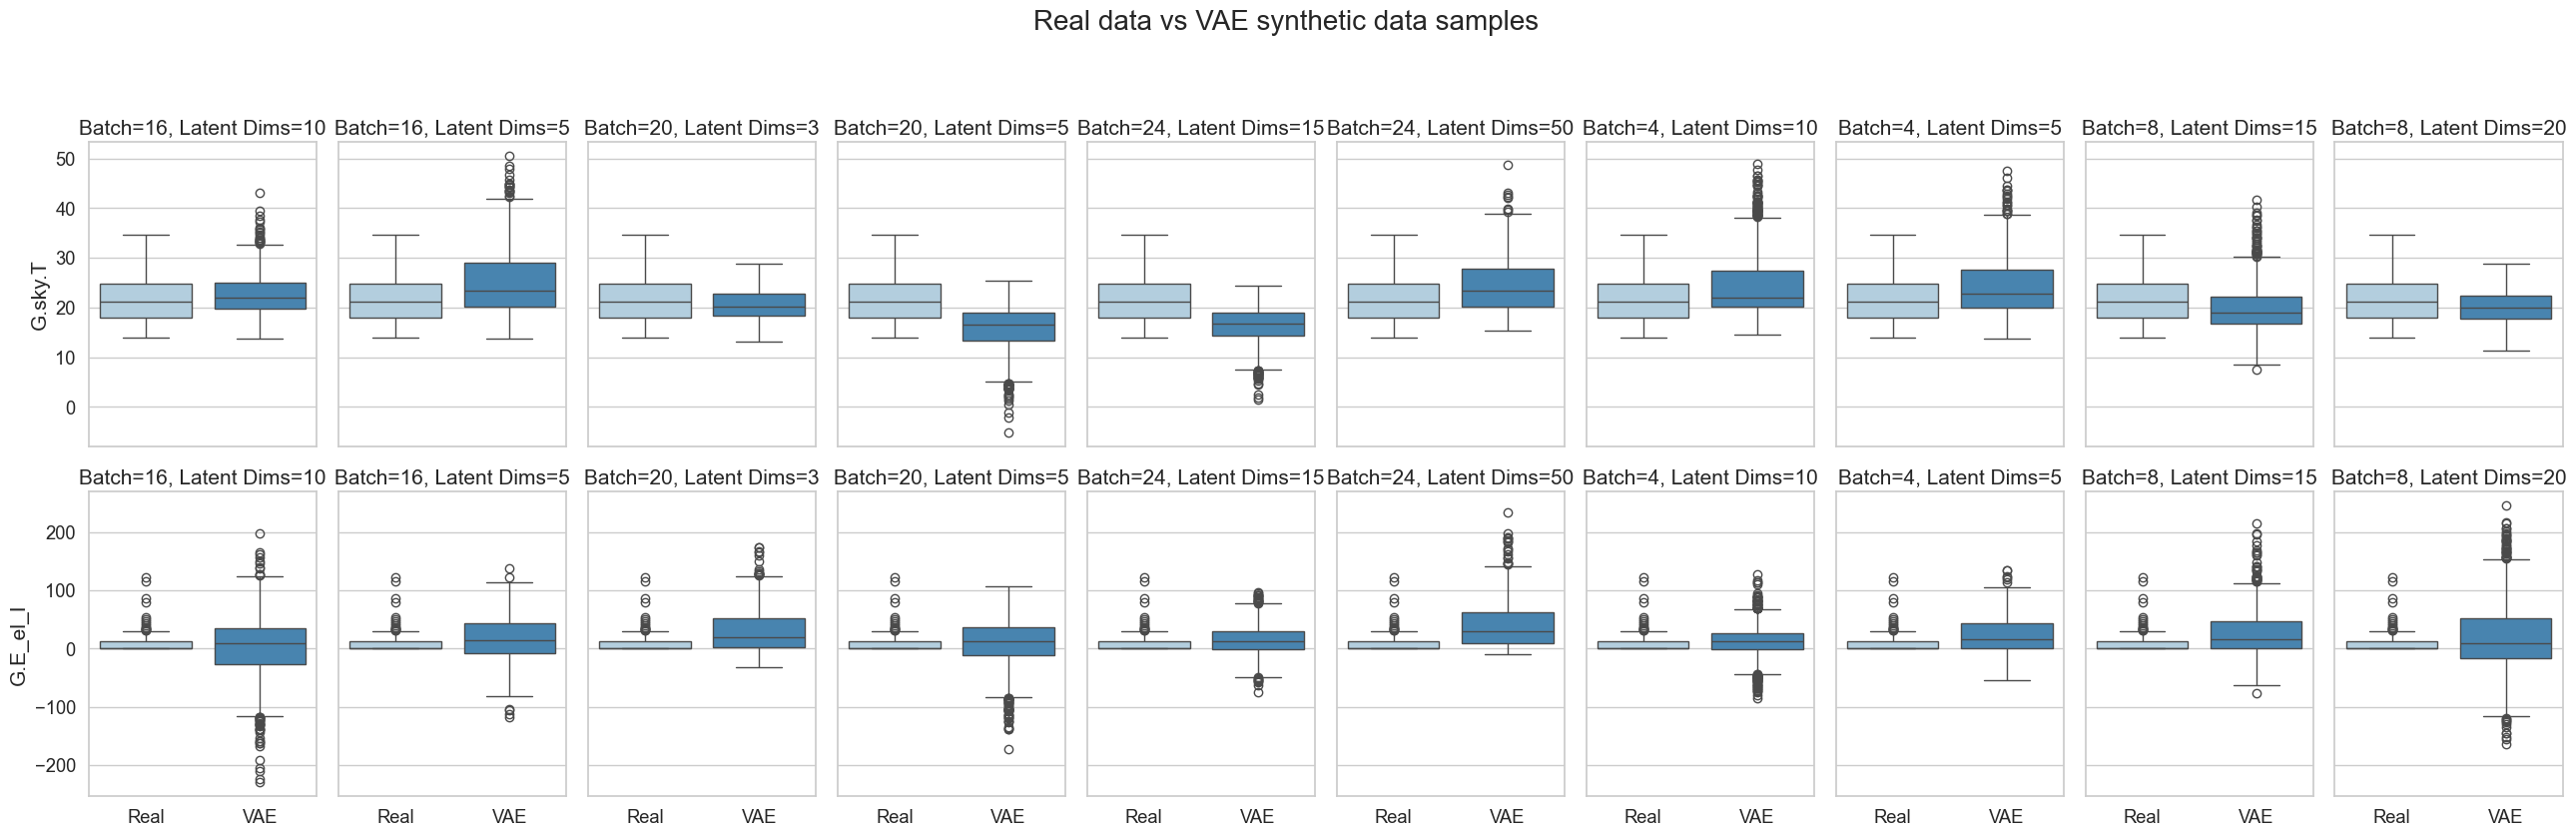

In [70]:
import re

sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(2, len(vae_data), figsize=(26, 8), sharey='row', sharex=True)

for column_name in [0, 1]:
    real_df = pd.DataFrame(base_data[:,:,column_name])
    df_list = [pd.DataFrame(df[:,:,column_name]) for df in vae_data]

    for i, df in enumerate(df_list):
        match = re.search(r'b(\d+)l(\d+)', vae_files[i])
        b, l = match.groups()

        combined_data = pd.DataFrame({
            'Type': ['Real']*len(real_df[0]) + ['VAE']*len(df[0]),
            'Value': pd.concat([real_df[0], df[0]], ignore_index=True)
        })

        sns.boxplot(x='Type', y='Value', data=combined_data, ax=ax[column_name, i], palette="Blues")
        ax[column_name, i].set_title(f'Batch={b}, Latent Dims={l}', fontsize=15)
        ax[column_name, i].set_xlabel('') 

    ax[column_name, 0].set_ylabel('G.sky.T' if column_name == 0 else 'G.E_el_I', fontsize=15)

fig.suptitle('Real data vs VAE synthetic data samples', fontsize=20, y=1.05)

plt.tight_layout()
plt.show()#savefig(f'../imgs/vae_data/VAE_{model_name}_boxplot_comparisons.pdf', format='pdf', transparent=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_5080\3125712694.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[column_name, i].set_xticklabels(['Real', 'GAN data'])
C:\Users\matth\AppData\Local\Temp\ipykernel_5080\3125712694.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[column_name, i].set_xticklabels(['Real', 'GAN data'])
C:\Users\matth\AppData\Local\Temp\ipykernel_5080\3125712694.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[column_name, i].set_xticklabels(['Real', 'GAN data'])
C:\Users\matth\AppData\Local\Temp\ipykernel_5080\3125712694.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[column_name, i].set_xticklabels(['Real', 'GAN data'])
C:\Users\matth\AppData\Local\Temp\ipykernel_5080\3125712694.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[column_name, i].set_xticklabels(['Real', 'GAN dat

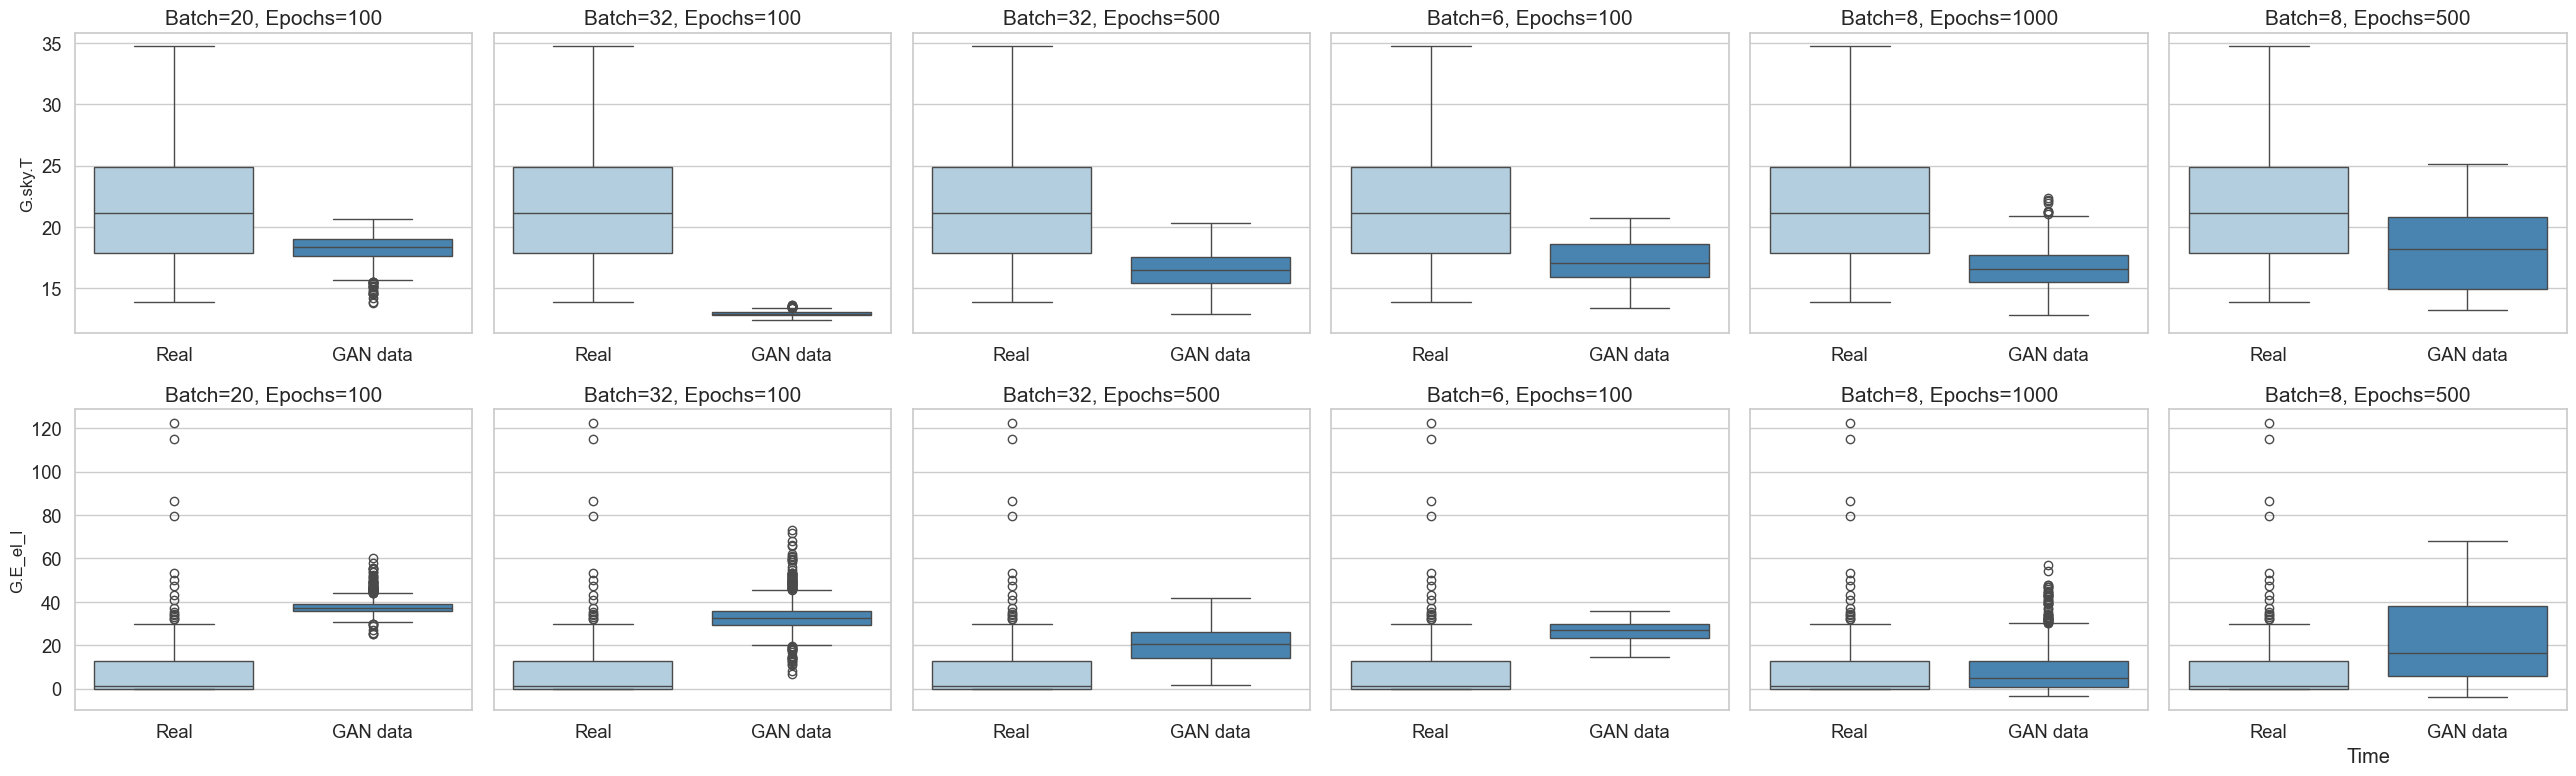

In [74]:
import re

sns.set(style="whitegrid", font_scale=1.2)

fig, ax = plt.subplots(2, len(gan_data), figsize=(26, 8), sharey='row')
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for column_name in [0, 1]:
    real_df = pd.DataFrame(base_data[:, :, column_name])
    df_list = [pd.DataFrame(df[:, :, column_name]) for df in gan_data]

    for i, df in enumerate(df_list):
        match = re.search(f'b(\d+)e(\d+)', gan_files[i])
        b, e = match.groups()

        sns.boxplot(data=[real_df[0].values, df[0].values], ax=ax[column_name, i], palette="Blues")
        ax[column_name, i].set_title(f'Batch={b}, Epochs={e}', fontsize=15)
        ax[column_name, i].set_xticklabels(['Real', 'GAN data'])

    ax[column_name, 0].set_ylabel('G.sky.T' if column_name == 0 else 'G.E_el_I', fontsize=12)

plt.xlabel('Time')

plt.tight_layout()
plt.show()#savefig(f'../imgs/gan_data/DGAN_{model_name}_boxplot_comparisons.pdf', format='pdf', transparent=True)

<h3> Boxplots </h3>

In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_box(real_data, fake_data, features, y_labels, dir):
    sns.set(style="whitegrid", font_scale=1.2)
    
    real_data = np.array(real_data)
    fake_data = np.array(fake_data)
    
    print("Real data shape:", real_data.shape)
    print("Fake data shape:", fake_data.shape)
    
    fig, axs = plt.subplots(1, len(features), figsize=(6 * len(features), 8))
    
    for index, ax in enumerate(axs):
        data = {
            'Value': np.concatenate([real_data[:, :, index].flatten(), fake_data[:, :, index].flatten()]),
            'Type': ['Ground Truth'] * len(real_data[:, :, index].flatten()) + ['Synthetic'] * len(fake_data[:, :, index].flatten()),
            'Feature': [features[index]] * (len(real_data[:, :, index].flatten()) + len(fake_data[:, :, index].flatten()))
        }
        df = pd.DataFrame(data)
        sns.boxplot(x='Feature', y='Value', hue='Type', data=df, palette="Blues", ax=ax)
        ax.set_title(f'Comparison for {features[index]}')
        ax.set_xlabel('')
        ax.set_ylabel(y_labels[index])

    plt.tight_layout()
    plt.savefig(f'../imgs/{dir}/{model_name}_boxplots.png', format='png', transparent=True)


Real data shape: (108, 730, 2)
Fake data shape: (1000, 730, 2)
Real data shape: (108, 730, 2)
Fake data shape: (1000, 730, 2)


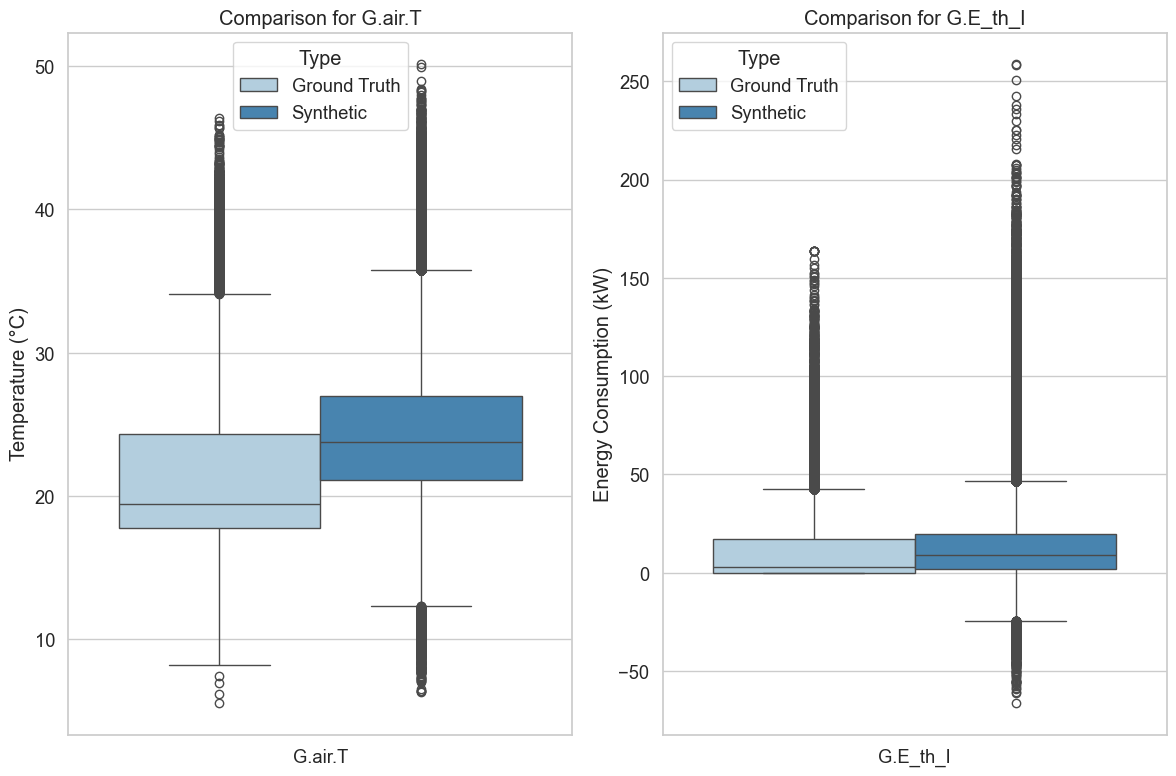

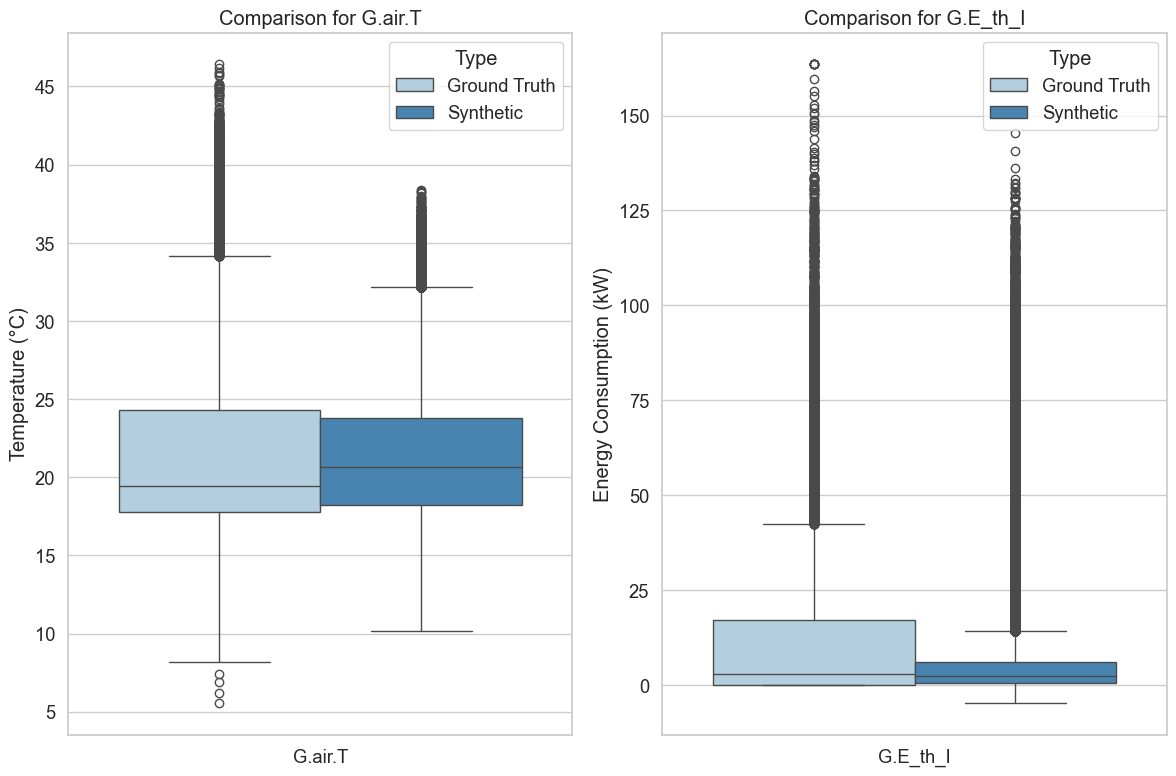

In [125]:
plot_box(base_data, best_vae_data, features, ['Temperature (°C)', 'Energy Consumption (kW)'], 'vae_data')
plot_box(base_data, best_gan_data, features, ['Temperature (°C)', 'Energy Consumption (kW)'], 'gan_data')

<h3> QQ plots </h3>

In [181]:
from scipy import stats

def plot_qq(real_data, synthetic_data, features, labels, dir):
    sns.set(style="whitegrid", font_scale=1.2, palette='Blues_d')
    
    fig, axes = plt.subplots(1, len(features), figsize=(6 * len(features), 6))
    
    if len(features) == 1:
        axes = [axes]
    
    for feature_index, feature in enumerate(features):
        ax = axes[feature_index]
        real_data_flattened = real_data[:, :, feature_index].flatten()
        synthetic_data_flattened = synthetic_data[:, :, feature_index].flatten()

        real_df = pd.DataFrame(real_data_flattened, columns=['Real Data'])
        synthetic_df = pd.DataFrame(synthetic_data_flattened, columns=['Synthetic Data'])
        
        synthetic_df = synthetic_df.iloc[:len(real_df)]

        quantiles = np.linspace(0, 1, 100)
        real_quantiles = np.quantile(real_df, quantiles)
        synthetic_quantiles = np.quantile(synthetic_df, quantiles)

        ax.plot(real_quantiles, real_quantiles, linestyle='--', color='coral', label='Ground Truth')
        ax.scatter(real_quantiles, synthetic_quantiles, color='cornflowerblue', alpha=0.5, label='Synthetic')
        ax.set_xlabel(f'Quantiles, {labels[feature_index]}')
        ax.set_ylabel(f'Quantiles, {labels[feature_index]}')
        ax.set_title(f'QQ Plot for {feature}')
        ax.legend()

    plt.tight_layout()
    plt.savefig(f'../imgs/{dir}/{model_name}_qq.png', format='png', transparent=True)


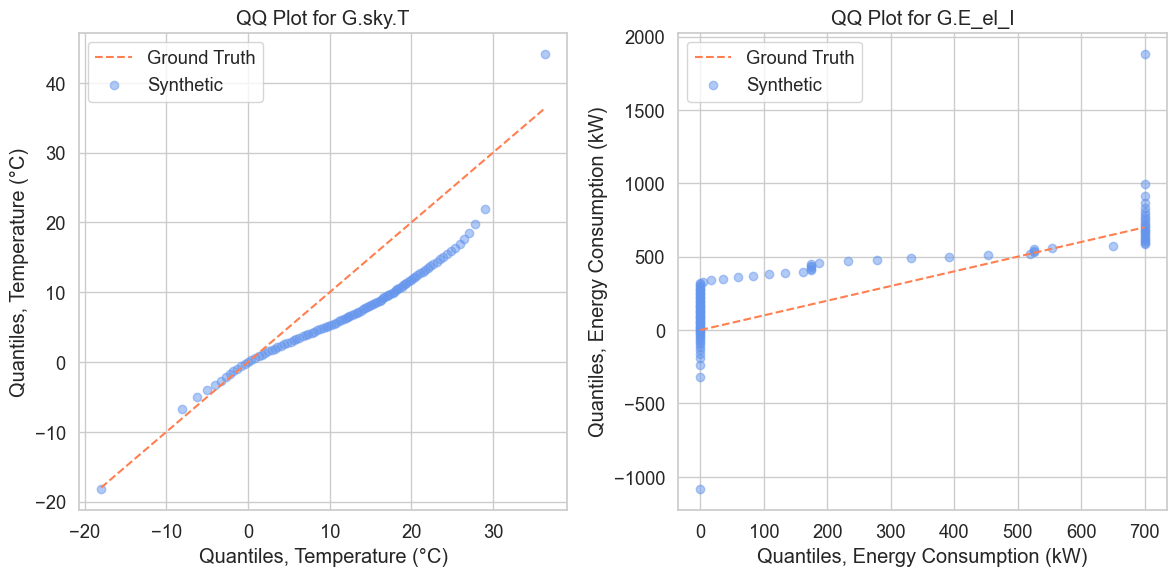

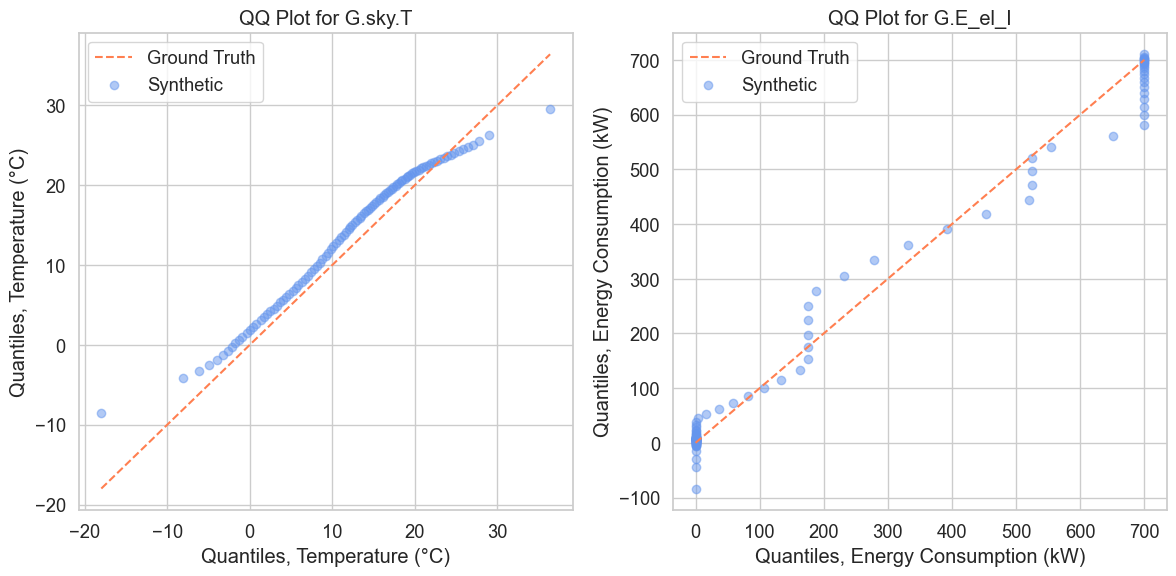

In [182]:
plot_qq(base_data, best_vae_data, features, ['Temperature (°C)', 'Energy Consumption (kW)'], 'vae_data')
plot_qq(base_data, best_gan_data, features, ['Temperature (°C)', 'Energy Consumption (kW)'], 'gan_data')

<h3> KDE plot </h3>

In [210]:
def plot_kde(synthetic_data, real_data, dir):
    sns.set(style="whitegrid", font_scale=1.2, palette="coolwarm")

    fig, axes = plt.subplots(1, len(features), figsize=(6 * len(features), 4))
    
    if len(features) == 1:
        axes = [axes]
    
    for feature_index, ax in enumerate(axes):
        synthetic_feature_values = synthetic_data[:, :, feature_index].flatten()
        real_feature_values = real_data[:, :, feature_index].flatten()

        sns.kdeplot(synthetic_feature_values, label="Synthetic", color='cornflowerblue', bw_adjust=0.5, alpha=0.6, ax=ax)
        sns.kdeplot(real_feature_values, label="Ground Truth", color='coral', bw_adjust=0.5, ax=ax)
        
        ax.set_title(f"Kernel Density Estimation for {features[feature_index]}")
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()

    plt.tight_layout()
    plt.savefig(f'../imgs/{dir}/{model_name}_kde.pdf', format='pdf', transparent=True)


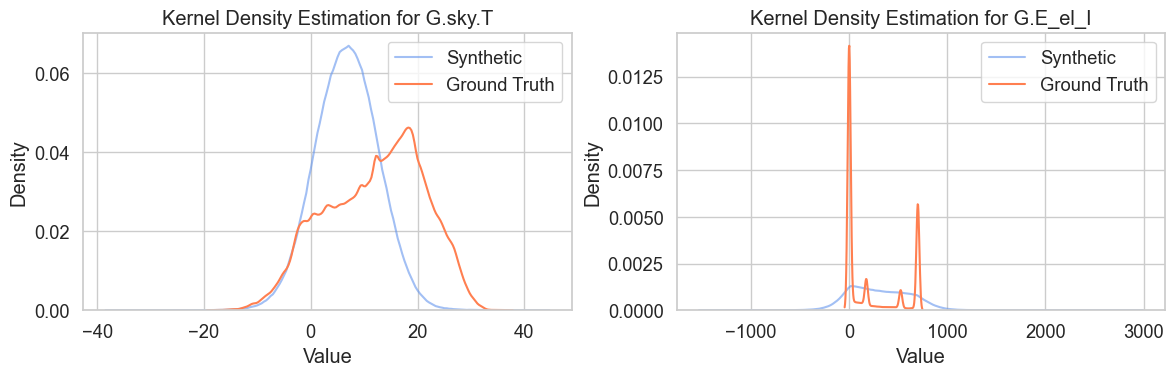

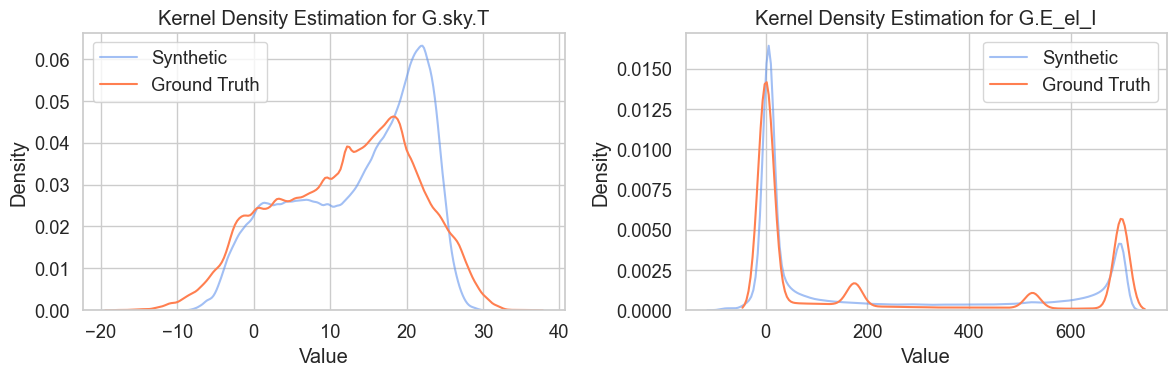

In [219]:
plot_kde(best_vae_data, base_data, 'vae_data')
plot_kde(best_gan_data, base_data, 'gan_data')

<h3> Statistical measures </h3>

In [243]:
base_data_flat, vae_data_flat, gan_data_flat = base_data.reshape(-1,2), best_vae_data.reshape(-1,2), best_gan_data.reshape(-1,2)

print('Real', pd.DataFrame(base_data_flat,columns=features).describe(), '\n')
print('VAE', pd.DataFrame(vae_data_flat,columns=features).describe(), '\n')
print('GAN', pd.DataFrame(gan_data_flat,columns=features).describe(), '\n')

Real             G.sky.T      G.E_el_I
count  78840.000000  78840.000000
mean      12.088530    219.182292
std        9.115832    292.392801
min      -18.000000      0.000000
25%        5.100000      0.000000
50%       13.100000      0.000000
75%       19.000000    524.999935
max       36.400000    700.000000 

VAE              G.sky.T       G.E_el_I
count  730000.000000  730000.000000
mean        6.727998     311.996338
std         5.932493     302.456970
min       -37.848522   -1499.402954
25%         2.728434      71.426579
50%         6.747271     289.176193
75%        10.732082     544.047516
max        44.096870    2961.073975 

GAN              G.sky.T       G.E_el_I
count  730000.000000  730000.000000
mean       13.661180     215.293762
std         8.484941     276.513397
min        -8.671929     -87.077919
25%         6.644219       5.778291
50%        15.657216      25.872698
75%        20.941788     499.733116
max        29.940760     714.486389 



In [234]:
print('Real', pd.DataFrame(base_data_flat,columns=features).skew(), '\n')
print('VAE', pd.DataFrame(vae_data_flat,columns=features).skew(), '\n')
print('GAN', pd.DataFrame(gan_data_flat,columns=features).skew(), '\n')

Real G.air.T     1.166710
G.E_th_I    2.319869
dtype: float64 

VAE G.air.T     0.50642
G.E_th_I    2.16287
dtype: float32 

GAN G.air.T     0.538144
G.E_th_I    3.503713
dtype: float32 



In [235]:
print('Real', pd.DataFrame(base_data_flat,columns=features).kurtosis(), '\n')
print('VAE', pd.DataFrame(vae_data_flat,columns=features).kurtosis(), '\n')
print('GAN', pd.DataFrame(gan_data_flat,columns=features).kurtosis(), '\n')

Real G.air.T     1.279467
G.E_th_I    6.829065
dtype: float64 

VAE G.air.T     0.439633
G.E_th_I    8.337177
dtype: float32 

GAN G.air.T     -0.037573
G.E_th_I    15.333066
dtype: float32 



<h3> Loss curves </h3>

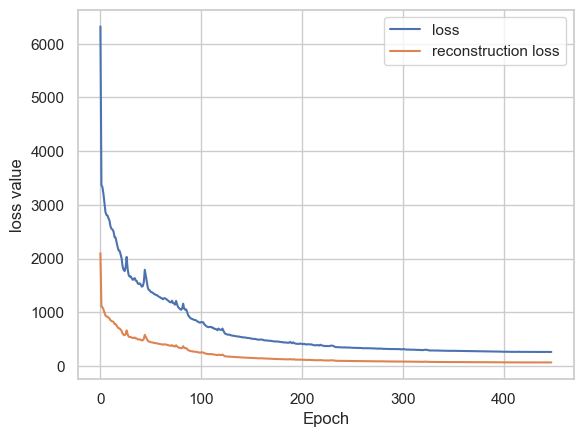

In [38]:
loss = pd.read_csv(f'../data/models/model_history/{model_name}_loss.csv')
plt.plot(loss['loss'], label='loss')
plt.plot(loss['reconstruction_loss'], label='reconstruction loss')
plt.xlabel('Epoch')
plt.ylabel('loss value')
plt.legend()
plt.savefig(f'../imgs/vae_data/{model_name}_loss_curve.png')

In [284]:
def plot_feature_comparison(real_data, synthetic_data, features, labels, dir, segments=100):
    sns.set(style="whitegrid", font_scale=1.2)
    
    fig, axes = plt.subplots(1, len(features), figsize=(10 * len(features), 6))
    
    if len(features) == 1:
        axes = [axes]
    
    for feature_index, ax in enumerate(axes):
        # Extracting a segment for comparison
        real_segment = real_data[:, :, feature_index].flatten()[:segments]
        synthetic_segment = synthetic_data[:, :, feature_index].flatten()[:segments]
        timeline = np.arange(len(real_segment))

        # Create a DataFrame for easier plotting
        df_real = pd.DataFrame({'Time': timeline, 'Value': real_segment, 'Type': 'Ground Truth'})
        df_synthetic = pd.DataFrame({'Time': timeline, 'Value': synthetic_segment, 'Type': 'Synthetic'})
        df_combined = pd.concat([df_real, df_synthetic])

        # Plotting
        sns.lineplot(data=df_combined, x='Time', y='Value', hue='Type', style='Type', ax=ax, palette=['cornflowerblue', 'coral'], linewidth=0.9)
        ax.set_title(f'Feature Comparison for {labels[feature_index]}')
        ax.set_xlabel('Time (hrs)')
        ax.set_ylabel(f'{labels[feature_index]}')

    plt.tight_layout()
    plt.savefig(f'../imgs/{dir}/{model_name}_plot.pdf', format='pdf', transparent=True)
    

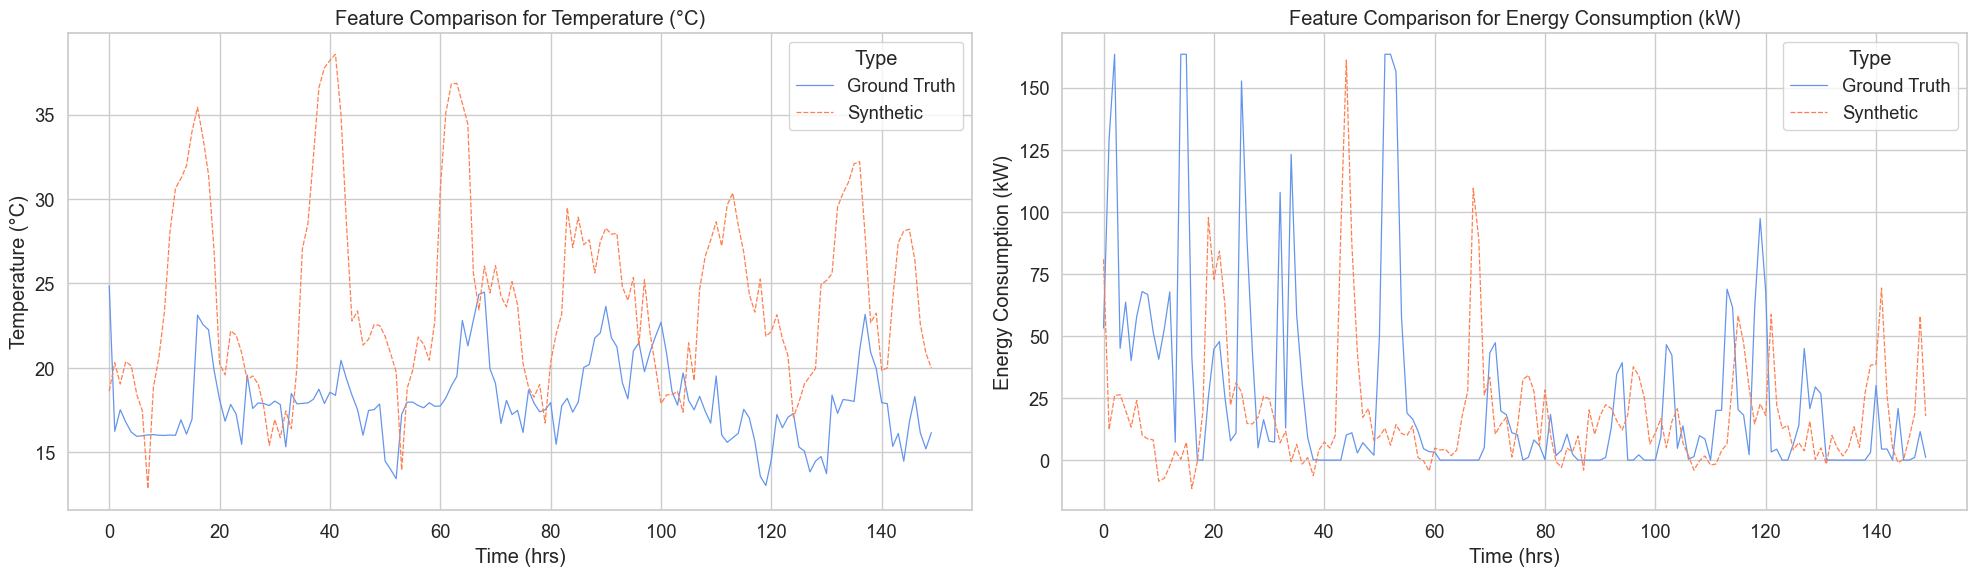

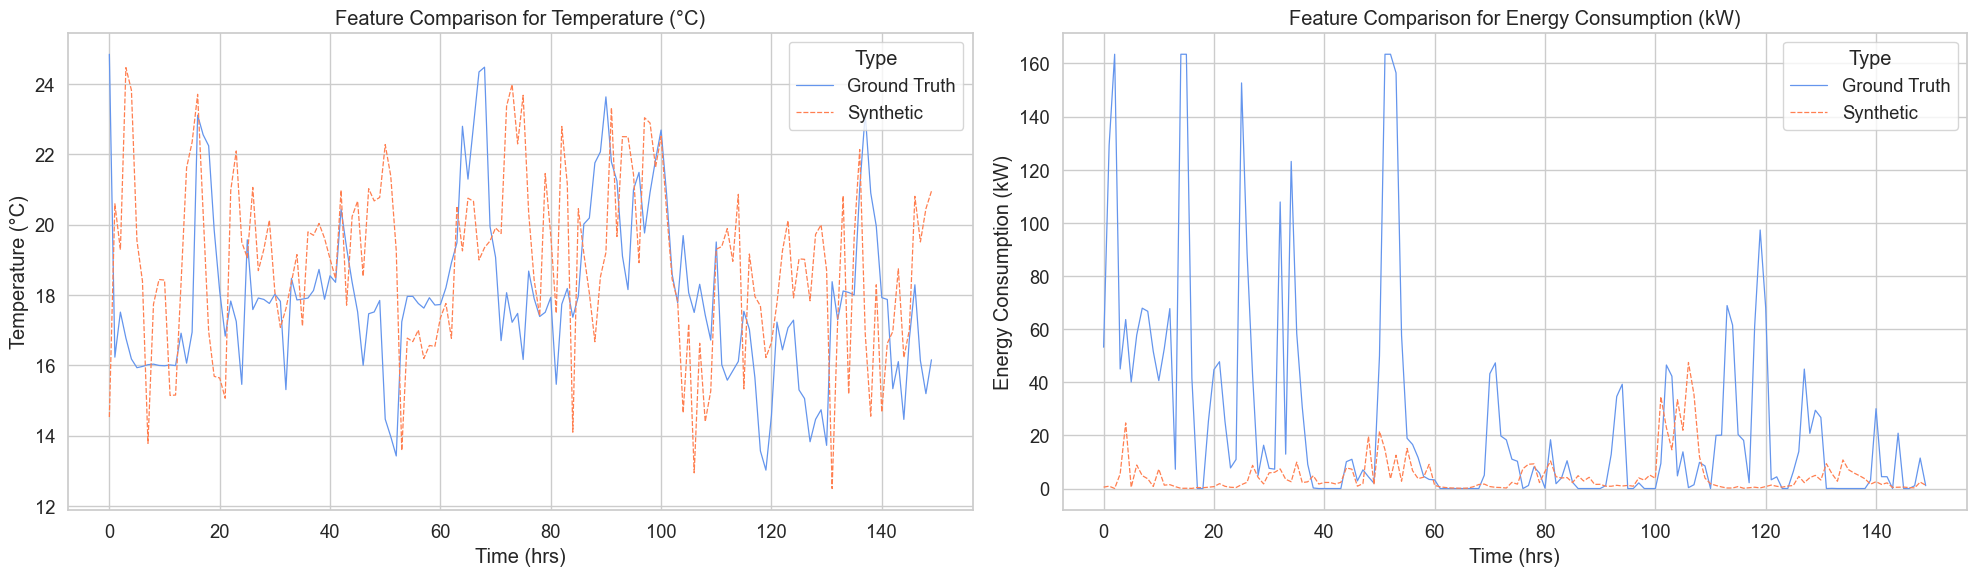

In [285]:
plot_feature_comparison(base_data, best_vae_data, features, ['Temperature (°C)', 'Energy Consumption (kW)'], 'vae_data', 150)
plot_feature_comparison(base_data, best_gan_data, features, ['Temperature (°C)', 'Energy Consumption (kW)'], 'gan_data', 150)